<center>
<h2>IPM-407: Modelación Computacional con Algoritmos Rápidos</h2>
<h3>Proyecto 3 - Transformada Rápida de Gauss</h3>
<h4>Daniel San Martín</h4>
</center>

# Outline
* [1. Introduction](#introduction)
* [2. Content](#content)
* [3. Conclusions](#conclusions)
* [4. References](#references)

<div id="introduction" />
## 1. Introduction

### 1.1 Gauss Transform

Many problems in applied mathematics involve the *Gauss Transform*

\begin{equation}
    \displaystyle
    G_{\delta}f(x) = \int_{\Gamma}e^{-|x-y|^2/\delta}f(y)dy \quad (\delta > 0)
\end{equation}

of a function $f$ defined on $\Gamma \subset \mathbb{R}^d$.

### 1.2 Discrete Gauss Transform 

For numerical purposes, one must discretize $G_{\delta}f$. Given the values of $f$ at a set of points $s_j \in\mathbb{R}^d$, we can approximate the integral using a quadrature formula. Then, a reasonable approximation of $G_{\delta}f$ might then take the form of a *discrete Gauss transform*
\begin{equation}
    G(x) = \sum_{j=1}^N q_j e^{-|x-s_j|^2/\delta},
\end{equation}
where the coefficients $q_j$ depend of the values $f(s_j)$ and the weights of the chosen quadrature formula.

<div id="content"  />
## 2. Content

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.special import hermite
from scipy.misc import factorial
from point2d import *

### Multi-index implementation

A multi-index $\alpha=(\alpha_1, \alpha_2, ..., \alpha_d)$ is a $d$-duple of nonnegative integers, playing role of a multidimensional index. For any multi-index $\alpha$ and any
$t\in\mathbb{R}^d$, we define

\begin{equation}
\begin{split}
    |\alpha| & = \alpha_1 + \alpha_2 + ... + \alpha_d,\\ 
    \alpha ! & = \alpha_1!\alpha_2!...\alpha_d !, \\
    t^{\alpha} & = t_1^{\alpha_1}t_2^{\alpha_2}...t_d^{\alpha_d}, \\
    D^{\alpha} &= \partial_1^{\alpha_1}\partial_2^{\alpha_2}...\partial_d^{\alpha_d}
\end{split}
\end{equation}

where $\partial_i$ is differentation with respect to the $i$th coordinate in $\mathbb{R}^d$. If $p$ is an integer, we say $\alpha \geq p$ if $\alpha_i \geq p$ for $1\leq i \leq d$.

In [2]:
# |alpha|
def abs_alpha(alpha):
    return np.sum(alpha)

In [3]:
# alpha!
def fact_alpha(alpha):
    return np.prod(factorial(alpha))

In [4]:
# Generate multi-index alpha
def gen_alpha(p):
    alpha = []
    for i in range(p):
        for j in range(p-i):
            alpha.append([i,j])
    return alpha

In [5]:
def build_fact_cache(q):
    f = np.zeros(q+1)
    for i in range(q+1):
        f[i] = factorial(i)
    return f

In [6]:
# Generate sources
def gen_sources(N):
    r = [None]*N
    for i in range(len(r)):
        X = np.random.random()
        Y = np.random.random()
        gamma = np.random.random()
        r[i] = point2d(X, Y, gamma,i)
    return r

In [7]:
# Generate targets
def gen_targets(N):
    r = [None]*N
    for i in range(N):
        X = np.random.random()
        Y = np.random.random()
        r[i] = point2d(X, Y, 0, i)
    return r

In [8]:
# Contour plot
def contour_plot(pts):
    # read X and Y from path given
    n = len(pts)
    X_pts = np.zeros(n)
    Y_pts = np.zeros(n)
    for i in range(n):
        X_pts[i] = pts[i].x
        Y_pts[i] = pts[i].y

    plt.contour(X_pts, Y_pts, pts[:,:,2], n)
    plt.colorbar()
    plt.show()

In [9]:
# Scatter plot
def scatter_plot(t, r):
    n = len(t)
    x = np.zeros(n)
    y = np.zeros(n)
    for i in range(n):
        x[i] = t[i].x
        y[i] = t[i].y

    area = 100 * np.pi * r**2
    plt.scatter(x, y, c = r[0], marker = 'o', s = area, cmap=cm.jet, alpha=0.5)#, edgecolors='none')
    plt.colorbar()
    plt.show()

In [10]:
# Source and target plot
def st_plot(s, t):
    sX = np.zeros(len(s))
    sY = np.zeros(len(s))
    tX = np.zeros(len(t))
    tY = np.zeros(len(t))
    
    for i in range(len(s)):
        sX[i] = s[i].x
        sY[i] = s[i].y
        
    for i in range(len(t)):
        tX[i] = t[i].x
        tY[i] = t[i].y

    plt.plot(sX, sY, 'ro', label="Sources")
    plt.plot(tX, tY, 'bx', label="Targets")
    plt.legend()
    plt.show()

In [11]:
def plot(s, t, r):
    sX = np.zeros(len(s))
    sY = np.zeros(len(s))
    tX = np.zeros(len(t))
    tY = np.zeros(len(t))
    
    for i in range(len(s)):
        sX[i] = s[i].x
        sY[i] = s[i].y
        
    for i in range(len(t)):
        tX[i] = t[i].x
        tY[i] = t[i].y
        
    area = 100 * np.pi * r**2
    
    plt.figure(figsize=(12, 8))
    plt.plot(sX, sY, 'ko', label="Sources")
    plt.plot(tX, tY, 'kx', label="Targets")
    plt.scatter(tX, tY, c = r, marker = 'o', s = area, cmap=cm.jet, alpha=0.5)
    plt.colorbar()
    plt.legend()
    plt.show()

#### Transform the field due to all sources in a box into a single rapidly converging Hermite expansion about the center of the box.

*Lemma 2.1* Let $N_B$ sources $s_j$ lie in a box $B$ with center $s_B$ and side length $r\sqrt{2\delta}$ with $r < 1$. Then the Gaussian field due to the sources in $B$,

$$\displaystyle G(t) = \sum_{j=1}^{N_B}q_je^{-|t-s_j|^2/\delta}$$

is equal to a single Hermite expansion about $s_B$:
\begin{equation}
    G(t) = \sum_{\alpha\geq 0} A_{\alpha}h_{\alpha}\left(\frac{t-s_B}{\sqrt{\delta}}\right)
\end{equation}
The coefficients $A_{\alpha}$ are given by
\begin{equation}
    A_{\alpha} = \frac{1}{\alpha !}\sum_{j=1}^{N_B}q_j\left(\frac{s_j - s_B}{\sqrt{\delta}}\right)^{\alpha}
\end{equation}

In [12]:
def A_alpha(s, sb, delta, alpha):
    """
    Build A_alpha coefficients
    
    Inputs:
        - s: Source points
        - q: Source strengths
        - sb: Center of cluster
        - delta: Gaussian width
        - alpha: alpha multi-index
    Return:
        - A: array of coefficients
    """
    A = np.zeros(len(alpha))

    # Go over each alpha value
    for i in range(len(alpha)):
        alp_temp = alpha[i]
        A_tmp = 0.
        
        # Sum over all the source points
        for j in range(len(s)):
            A_tmp += s[j].gamma * ((s[j] - sb) / math.sqrt(delta))**alp_temp
            
        A[i] = A_tmp / (1.*fact_alpha(alp_temp))
    return A

Rather than using *Lemma 2.1* to accumulate all the Gaussians into a single Hermite expansion and then shifting it to $t_C$, we can use *Lemma 2.3* to shift each Gaussian individually to $t_C$ and add up the resulting Taylor coefficients. (A Gaussian is a one-term Hermite series, after all, and can therefore be shifted just like any other truncated Hermite series.) Thus, a Gaussian
\begin{equation}
    G(t) = qe^{-|t-s_j|^2/\delta}
\end{equation}
has the following Taylor expansion about $t_C$:
\begin{equation}
    G(t) = \sum_{\beta\geq 0}B_{\beta}\left(\frac{t-t_C}{\sqrt{\delta}}\right)^{\beta}.
\end{equation}
The coefficients $B_{\beta}$ are given by
\begin{equation}
    B_{\beta} = q\frac{(-1)^{|\beta|}}{\beta !}h_{\beta}\left(\frac{s_j-t_C}{\sqrt{\delta}}\right)
\end{equation}

In [57]:
def B_beta(s, tc, delta, beta, H):
    """
    Directly get taylor coefficients for target cluster rather than translate from hermite series
    
    Inputs:
        - s: Source points
        - tc: Center of targets' cluster
        - delta: Gaussian width
        - beta: beta multi-index coefficients
        - H: list of pre-computed hermite polynomials
        
    Return:
        - B: array of coefficients
    """
    B = np.zeros(len(beta))

    for i in range(len(beta)):
        sign = ((-1)**(1.*abs_alpha(beta[i]))) / (1.*fact_alpha(beta[i]))
        B_tmp = 0.
        
        # For each point, work out the expansion
        for j in range(len(s)):
            q = s[j].gamma
            x = (s[j]-tc) / math.sqrt(delta)

            t = ((x.x)**2) + ((x.y)**2)

            temp = np.exp(-t)*(H[beta[i][0]](x.x))*(H[beta[i][1]](x.y))
            B_tmp += q*sign*temp

        B[i] = B_tmp

    return B

The algorithm needs a variant of *Lemma 2.2* in which the Hermite series is truncated before converting it to a Taylor series. This essentially means that in addition to truncating the Taylor series itself, we are also truncating the infinite sum expression (15) for the coefficients. Fortunately, however, the error due to this approximation of the coefficients turns out to be much smaller than the truncation error of the Taylor series.
*LEMMA 2.3.* A truncated Hermite expansion
\begin{equation}
    G(t) = \sum_{\alpha\leq p}A_{\alpha}h_{\alpha}\left(\frac{t-s_B}{\sqrt{\delta}}\right)
\end{equation}
has the following Taylor expansion about an arbitrary point $t_C$:
\begin{equation}
    G(t) = \sum_{\beta\geq 0}C_{\beta}\left(\frac{t-t_C}{\sqrt{\delta}}\right)^{\beta}.
\end{equation}
The coefficients $C_{\beta}$ are given by
\begin{equation}
    C_{\beta} = \frac{(-1)^{|\beta|}}{\beta !}\sum_{\alpha\leq p}A_{\alpha}h_{\alpha + \beta}\left(\frac{s_B-t_C}{\sqrt{\delta}}\right).
\end{equation}

In [14]:
def C_beta(sb, tc, A, delta, p, q, alpha, beta, H):
    """
    Translate hermite series about sources into taylor series about target cluster center 
    (doesn't depend on source pts)
    
    Inputs: 
        - sb: Old cluster center
        - tc: New center of series
        - A: Array of A_alpha values for cluster with center sb
        - delta:
        - beta: Beta multi-index
        - H: List of pre-computed hermite polynomials
        
    Return:
        - C: array of coefficientes
    """
    C = np.zeros(len(beta))
    
    for i in range(len(beta)):
        sign  = ((-1.)**(1.*abs_alpha(beta[i]))) / (1. * fact_alpha(beta[i]))
        B_tmp = 0.
        
        # iterate over A_alpha values
        for j in range(len(A)):
            a = A[j]
            x = (sb-tc) / math.sqrt(delta)
            t = (x.x)**2 + (x.y)**2
            
            #h1 = H[alpha[j, 0] + beta[i, 0]](x.x)
            #h2 = H[alpha[j, 1] + beta[i, 1]](x.y)
            h1 = H[alpha[j][0] + beta[i][0]](x.x)
            h2 = H[alpha[j][1] + beta[i][1]](x.y)

            B_tmp += a*np.exp(-t)*h1*h2
        C[i] = B_tmp*sign
    
    return C

In [15]:
def int_list(A, i, j, d):
    """
    Get the interaction list from A about cluster (i,j) with a distance of d in x, y directions.
    
    Inputs:
        - A: Cluster index array
        - i: Cluster row
        - j: Cluster column
        - d: Number of clusters in each direction
        
    Return:
        Interaction list
    """
    if (i-d < 0): y_min = 0
    else: y_min = i - d
        
    if (j-d < 0): x_min = 0
    else: x_min = j - d
        
    return A[y_min:i+d+1, x_min:j+d+1]

In [16]:
def direct_gaussian(s, t, delta, results):
    """
    Direct calculation of Gaussians
    
    Input: 
        - s: Source points
        - t: Target points
        - delta: Gaussian width
        - results: Array to update
    
    """
    for i in range(len(t)):
        r = 0
        
        # index of the target point - element of results to store in
        idx = t[i].idx
        for j in range(len(s)):
            dist = (s[j]-t[i]).norm()
            v = dist**2 / delta
            r += s[j].gamma*np.exp(-v)
            
        results[idx] += r
        
    return results

In [53]:
def eval_hermite(A_alpha, t, sb, delta, alpha, H):
    """
    Evaluate hermite expansion at a target point
    
    Inputs:
        - A_alpha: List of A series coefficients
        - t: Target point
        - sb: Center of source cluster (series center)
        - delta: Gauss width
        - alpha: Alpha multi-index
        - H: List of pre-computed hermite polynomials
    """
    r = 0.
    for i in range(len(alpha)):
        x = (t-sb) / sqrt(delta)
        pre_mult = A_alpha[i]*np.exp(-(x.x**2 + x.y**2))
        r  += pre_mult * H[alpha[i][0]](x.x) * H[alpha[i][1]](x.y)
    
    return r

In [18]:
def eval_taylor(t, tc, delta, t_series, beta):
    """
    Evaluate taylor series at a target point
    
    Inputs:
        - t: Target point
        - tc: Center of Taylor series
        - delta:
        - t_series: Taylor series coefficients
        - beta: Beta multi-index
    """
    x = (tc-t)/math.sqrt(delta)
    r = 0.
    
    for i in range(t_series.shape[1]):
        r += t_series[0,i]*(x**beta[i])

    return r

In [19]:
def gen_hermite_polys(p):
    """
    Pre-compute the hermite polynomials to be used throughout the calculations (for speed)
    
    Inputs:
        - p: number of terms kept in hermite / taylor series
    """
    H = []
    
    for i in range(p):
        H.append(hermite(i))
        
    return H

In [20]:
def nCp(n, p):
    """
    Get nCp needed for number of coefficients for taylor series
    
    Inputs:
        - n:
        - p:
    """
    top = factorial(n)
    bottom = factorial(p)*factorial(n-p)
    
    return int(1.*(top/bottom))

In [21]:
def sum_gamma(s):
    """
    Sum the gamma values to get Qb
    """
    q = 0.
    for i in s:
        q += i.gamma
        
    return q

In [22]:
# Compute cutoff parameters using error
def truncation_bound(Qb, r, eps):
    pre_mult = np.exp(-2.*(r**2))

    for n in range(10):
        e = pre_mult*np.exp(-n**2)

        if (e < eps):
            return n+1

    return n

In [23]:
# Compute Hermite cutoff parameters using error
def hermite_bound(Qb, r, eps):
    K = (1.09**2)

    for p in range(50):
        e = K*Qb*(1./factorial(p))*((r**(p+1))/(1-r))
        if (e <= eps):
            return p

    return p

In [24]:
# Compute Hermite cutoff parameters using error
def taylor_bound(Qb,r,eps):
    K = (1.09**2)
    
    for p in range(50):
        e = K*Qb*(1./factorial(p))*((r**(p+1))/(1-r))
        if e <= eps:
            return p

    return p

In [25]:
def cluster(pts, xb, yb):

    centers = [[] for _ in range(xb*yb)]
    # initialise list for storing points
    B = [[] for _ in range(xb*yb)]

    dx = 1. / xb
    dy = 1. / yb

    x_bounds = []
    y_bounds = []

    # calculate lists of x and y bounds
    # assume domain = [0,1]^2
    for i in range(xb + 1):
        x_bounds.append(i*dx)
    for i in range(yb + 1):
        y_bounds.append(i*dy)

    # assign the cluster centers
    for i in range(yb):
        for j in range(xb):
            y_center = (y_bounds[i] + y_bounds[i+1])/2.0
            x_center = (x_bounds[j] + x_bounds[j+1])/2.0

            centers[i*yb+j] = point2d(x_center,y_center)

    # now assign points into the appropriate boxes
    for i in range(len(pts)):
        X = pts[i].x
        Y = pts[i].y

        # get y box
        for j in range(yb):
            if (Y >= y_bounds[j] and Y > y_bounds[j+1]):
                # not in this box
                continue
            if (Y >= y_bounds[j] and Y <= y_bounds[j+1]):
                y_box = j
                break

        # get x box
        for k in range(xb):
            if (X >= x_bounds[k] and X > x_bounds[k+1]):
                continue
            if (X >= x_bounds[k] and X <= x_bounds[k+1]):
                x_box = k
                break

        B[y_box*yb + x_box].append(pts[i])

    # build index array
    A = np.zeros([xb,yb], dtype=int)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            A[i,j] = (i*xb)+j

    return A, B, centers

In [58]:
def FGT(opt):
    
    # Get options - Parameters
    N = opt['N']
    M = opt['M']
    r = opt['r']
    delta = opt['delta']
    N_side = opt['N_side']
    eps = opt['eps']

    # Generate random sources and targets
    s = gen_sources(N)
    t = gen_targets(M)

    # Sub-box size
    xb = yb = N_side

    # Particle gamma sum
    Qb = sum_gamma(s)
    
    # Terms for hermite expansion
    p = hermite_bound(Qb, r, eps)

    # Terms for taylor expansion
    q = taylor_bound(Qb, r, eps)

    # Build a factorial cache - only compute this crap once
    fact_cache = build_fact_cache(p+q)
    
    # Generate table of hermite polynomials
    H = gen_hermite_polys(p + q)
 
    # Series' cutoffs based on error bounds
    NF = p + 1
    ML = q + 1

    
    d = truncation_bound(Qb, r, eps)

    # cluster source and target points
    # A is the index matrix, B = source clusters, C = target clusters,
    A, B, sb = cluster(s, xb, yb)
    A, C, tb = cluster(t, xb, yb)
    
    # Generate alpha and beta multi-index vectors
    alpha = gen_alpha(p)
    beta = gen_alpha(q)

    # storage for taylor series & hermite series
    h_series = [[] for _ in range(xb*yb)]
    t_series = [[] for _ in range(xb*yb)]

    # loop over source boxes -> NB > NF: generate hermite series
    for i in range(xb):
        for j in range(yb):
            idx = A[i,j]

            NB  = len(B[idx])

            if (NB > NF):
                #print('generating hermite series for box (%d,%d)' %(i,j))

                h_series[idx] = A_alpha(B[idx], sb[idx], delta, alpha) 
            else:
                #print('NB < NF -> no hermite series generated')
                continue
                

    # loop over target boxes -> MC > ML: assign storage for taylor series
    for i in range(xb):
        for j in range(yb):
            idx = A[i,j]

            MC = len(C[idx])

            if (MC > ML):
                #print 'assigning storage for taylor series in box (%d,%d)' %(i,j)

                # no. terms from iFGT paper, pg. 7
                t_series[idx] = np.zeros((1, nCp(q+1,2)))
            else:
                continue
                #print 'MC < ML -> no storage assigned'

    # array to hold results in
    #results = np.zeros([1, len(t)])
    results = np.zeros(len(t))

    direct_eval = 0
    hermite_eval = 0
    taylor_convert = 0
    hermite_taylor = 0
    # loop over source boxes 
    # - form interaction list
    for i in range(yb):
        for j in range(xb):
            # get interaction list for source box (i,j)
            idx  = A[i,j]
            IL   = int_list(A,i,j,d)
            size = IL.shape

            NB = len(B[idx])

            if (NB == 0):
                continue
            elif (NB <= NF):
                # now loop over boxes in interaction list
                for y in range(size[0]):
                    for x in range(size[1]):
                        t_idx = IL[y,x]
                        MC = len(C[t_idx])
                        if (MC == 0):
                            continue
                        elif (MC <= ML):
                            # evaluate gaussians directly
                            #print 'direct gaussian - s=%d to t=%d' %(idx,t_idx)
                            results = direct_gaussian(B[idx],C[t_idx],delta,results)
                            #print 'evaluate gaussians directly'
                            direct_eval += 1
                        else:
                            #print 'convert each source to taylor series & add to box'

                            t_series[t_idx] += B_beta(B[idx],tb[t_idx],delta,beta,H)
                            taylor_convert += 1

            # else (NB > NF)
            else:
                # loop over IL
                for y in range(size[0]):
                    for x in range(size[1]):
                        # hermite expansions already formed
                        t_idx = IL[y,x]
                        MC    = len(C[t_idx])
                        if (MC == 0):
                            continue
                        elif (MC <= ML):
                            # evaluate hermite series at each target & add to accumulated potential
                            #print 'Evaluate Hermite & add to accumulated potential'
                            for k in range(len(C[t_idx])):
                                target_idx = C[t_idx][k].idx
                                # eval_hermite(A_alpha,t,sb,delta,alpha)
                                results[target_idx] += eval_hermite(h_series[idx],C[t_idx][k],sb[idx],delta,alpha,H)
                                #results[0, target_idx]
                            hermite_eval += 1
                        # else (MC > ML)
                        else:
                            #print 'convert hermite -> taylor & add to taylor for box C'
                            # h2t(), C_beta(sb, tc, A, delta, p, q, alpha, beta)
                            t_series[t_idx] += C_beta(sb[idx],tb[t_idx],h_series[idx],delta,p,q,alpha,beta,H)
                            hermite_taylor += 1

    # loop through target boxes evaluating taylor series if MC > ML
    taylor_eval = 0
    for i in range(yb):
        for j in range(xb):
            idx = A[i,j]
            MC = len(C[idx])

            if (MC == 0):
                continue
            elif (MC > ML):
                taylor_eval += 1
                #print 'evaluate taylor series for C at each target position'
                for k in range(MC):
                    target_idx = C[idx][k].idx
                    # eval_taylor(t,tc,delta,t_series,beta)
                    results[target_idx] += eval_taylor(C[idx][k],tb[idx],delta,t_series[idx],beta)
                    #results[0, target_idx]
                    
    output = {
        't': t,
        's': s,
        'r': results,
        'A': A,
        'B': B,
        'C': C,
        'sb': sb,
        'tb': tb
    }
    return output #t, s, results, A, B, C, sb, tb

In [50]:
parameters = {
    'N': 100,
    'M': 100,
    'r': 0.5,
    'delta': .5,
    'N_side': 4,
    'eps': 1e-14
}

In [31]:
#t, s, r, A, B, C, sb, tb = FGT(parameters)
out = FGT(parameters)

In [32]:
def GT(s, t, delta):
    r = np.zeros(len(t))
    
    for i in range(len(t)):
        for j in range(len(s)):
            dist = (s[j]-t[i]).norm()
            v = dist**2 / delta
            r[i] += s[j].gamma*np.exp(-v)
            
    return r

In [33]:
R = GT(out['s'], out['t'], parameters['delta'])

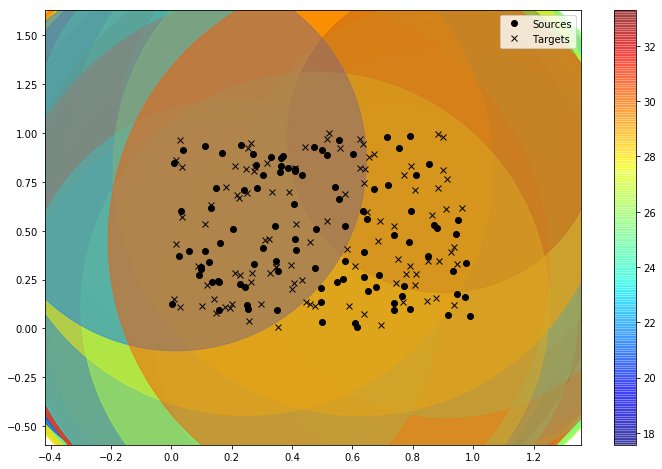

In [34]:
plot(out['s'], out['t'], out['r'])

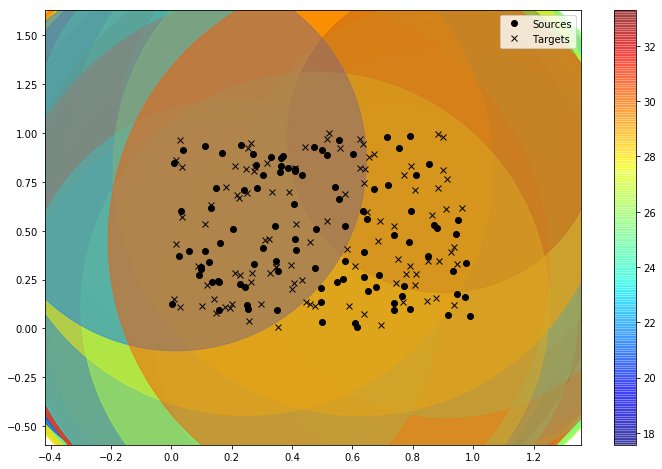

In [35]:
plot(out['s'], out['t'], R)

In [36]:
print(np.linalg.norm(R-out['r']))

7.95998165245e-14


In [59]:
parameters = {
    'N': 300,
    'M': 300,
    'r': 0.5,
    'delta': .5,
    'N_side': 4,
    'eps': 1e-14
}

In [60]:
out = FGT(parameters)

In [61]:
%timeit -r 1 -n 1 FGT(parameters)

1 loop, best of 1: 23.6 s per loop


In [62]:
%timeit -r 1 -n 1 GT(out['s'], out['t'], parameters['delta'])

1 loop, best of 1: 366 ms per loop


In [64]:
print(len(out['s']))

300


# <div id="desarrollo" />
## 2. Desarrollo

<!--
Consideren la siguiente ecuación de Poisson

\begin{equation}
    \frac{\partial^2\phi}{\partial x^2} + \frac{\partial^2\phi}{\partial y^2} = \frac{1}{\pi^2}
    \left[30\left(\left(\frac{x}{\pi}\right)^2-\frac{x}{\pi}\right) 
    + 30\left(\left(\frac{y}{\pi}\right)^2-\frac{y}{\pi}\right) - 4\pi^2\left(\frac{x}{\pi}-1 \right)\sin(2y) \right]
\end{equation}

en el cuadrado $0\leq x \leq \pi$ y $0 \leq y \leq \pi$ y con condiciones de contorno $\phi(0,y)=\phi(\pi,y)=\phi(x,0)=\phi(x,\pi)=0$. Resuelvan numéricamente esta ecuación usando

1. Método espectral
2. Diferencias finitas aceleradas con FFT en 2D (tipo pregunta 4 de la tarea 2)
3. Diferencias finitas aceleradas con FFT en 1D (tipo pregunta 5 de la tarea)

Para mallas de $N = 16, 32, 64$ y $128$ nodos (o más!) En su informe, detalle la implementación de cada técnica y discuta los siguientes puntos:

1. Convergencia del error.
2. Complejidad algoritmica ($N$ versus tiempo).
3. Memoria utilizada.
4. Conclusiones con respecto a la conveniencia de cada caso.

La solución analítica de esta ecuación es 
\begin{equation}
    \phi(x,y) = 15\left(\left(\frac{x}{\pi}\right)^2-\frac{x}{\pi}\right)
    \left(\left(\frac{y}{\pi}\right)^2-\frac{y}{\pi}\right)-\sin(2y)\frac{\sinh(2\pi(\frac{x}{\pi}-1))}{\sinh(2\pi)}
    + \left(\frac{x}{\pi}-1 \right)\sin(2y)
\end{equation}

### Ayuda

1. Esta tarea está inspirada en el Ejemplo 6.4 del libro *Fundamentals of Engineering Numerical Analysis* de Parviz Moin.
2. Las condiciones de borde homogénea $\phi = 0$ en los bordes son concordantes con la función seno, por lo tanto es más conveniente usar la transformada del seno. Hay una implementación de la transformada del seno en **scipy.fftpack**. Otra opción es calcular la transformada discreta del seno con FFTs de la forma:

```python
def dst_2D(x):
    M, N = numpy.shape(x)
    x = x[1:M−1,:]
    M,N = numpy.shape(x)
    y = numpy.zeros((2∗(M+1),N))
    y[0,:] = numpy.zeros(N)[:]
    y[1:M+1,:] = x[:,:]
    y[M+1,:] = numpy.zeros(N)[:]
    y[M+2:2∗M+ 2,:] = −numpy.flipud(x)[:,:]
    y_t = fft(numpy.transpose(y))
    y_t = numpy.transpose(y_t)
    y = numpy.real((y_t[1:M+1])/(−1j∗(M+1)))
    yy = numpy.zeros((M+2,N))
    yy[1:M+1,:] = y[:,:]
    return yy
```

```python
def dst_1D(x):
    M = len(x)
    x = x[1:M−1]
    M = len(x)
    y = array([0])
    y = numpy.append(y,x)
    y = numpy.append(y,0)
    y = numpy.append(y, −numpy.flipud(x))
    y_t = numpy.fft.fft(y)
    
    y = numpy.real(y_t[1:M+1]/(−1j ∗(M+1)))
    yy = numpy.array([0])
    yy = numpy.append(yy, y)
    yy = numpy.append(yy, 0)
    return yy
```
Considerando que la transformada inversa del seno es igual a la transformada del seno multiplicado por $N/2$
-->

### Implementación de funciones

In [ ]:
def L2_error(w, u):
    return np.sqrt(np.sum((w-u)**2)/np.sum(u**2))

In [ ]:
def convergence_plot(N, error_sp, error_d2, error_df):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.loglog(N, error_sp, 'b-*', label="Espectral")
    plt.loglog(N, error_d2, 'r-o', label="DF FFT 2D")
    plt.loglog(N, error_df, 'g-x', label="DF FFT")
    plt.title("Convergencia del error")
    plt.xlabel("N")
    plt.ylabel("Error")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return None

In [ ]:
def complexity_plot(N, time_sp, time_d2, time_df):
    plt.figure(figsize=(10, 6))
    plt.loglog(N, time_sp, 'b-*', label="Espectral")
    plt.loglog(N, time_d2, 'r-o', label="DF FFT 2D")
    plt.loglog(N, time_df, 'g-x', label="DF FFT")
    plt.title("Complejidad")
    plt.xlabel("N")
    plt.ylabel("Tiempo")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return None

<div id="conclusiones" />
## 3. Conclusiones

<!--
Del desarrollo del proyecto se obtuvieron las siguientes conclusiones:

* Es posible ver que el uso de métodos relacionados con la FFT (DST), tienen resultados cualitativamente buenos para la resolución de EDP's.
* La complejidad de los algoritmos indican que computacionalmente son métodos eficientes para este tipo de problemas.
* Según el análisis de los gráficos no existe una diferencia significativa en los resultados de cada algoritmo, pero aún así dependerá de los recursos de cómputo disponibles.
* Gracias a la optimización de las librerías para el cálculo de las FFT (DST), es posible obtener resultados en una cantidad de tiempo bastante inferior que aplicando los métodos usuales.
-->

<div id="referencias" />
## 4. Referencias 

* [1] Greengard, L., & Strain, J. (1991). The fast Gauss transform. SIAM Journal on Scientific and Statistical Computing, 12(1), 79-94.	
